# Analiza sentimenta primenjena na Amazon recenzije
Milica Sarić i Vladimir Luković

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import feature_extraction
from sklearn import model_selection
from sklearn import linear_model
from sklearn import svm
from sklearn import neighbors
from sklearn import metrics

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB

import time
import nltk
from nltk.corpus import stopwords

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vladimir.lukovic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Učitavanje podataka

In [3]:
data = pd.read_csv('baza/1429_1.csv', parse_dates=True)

C:\Users\vladimir.lukovic\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Osnovni uvid u podatke u bazi

In [4]:
print(f'U podacima imamo {data.shape[0]} instanci i {data.shape[1]} atribut')

U podacima imamo 34660 instanci i 21 atribut


In [5]:
data.head(2)

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman


In [6]:
print(f'Nasa baza na pocetku ima {len(data.columns)} atribut i njihova imena su:\n')
print(data.columns)

Nasa baza na pocetku ima 21 atribut i njihova imena su:

Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username'],
      dtype='object')


## Dokumentacija o značenjima atributa: [link](https://developer.datafiniti.co/docs/product-data-schema)

**ID** - ID vebsajta povezanog sa recenzijom
<br>**NAME** - ime proizvoda
<br>**ASINS** - lista amazon identifikatora za ovaj proizvod
<br>**BRAND** - ime brenda
<br>**CATEGORIES** - lista kategorija u kojima se proizvod nalazi (jedan proizvod se može nalaziti u više različitih kategorija)
<br>**KEYS** - interna oznaka Datafiniti-a za potrebe spajanja tabela
<br>**MANUFACTURER** - proizvođač proizvoda
<br>**REWIEWS.DATE** - datum recenzije
<br>**REWIEWS.DateADDED** - datum kada je proizvod prvi put dodat na listu proizvoda
<br>**REWIEWS.DateSEEN** - lista datuma kada je recenzija vidjen od strane Datafiniti-a
<br>**REWIEWS.DidPURCHASE** - (TRUE/FALSE) da li je klijent kupio proizvod
<br>**REWIEWS.DoRECOMMEND** - (TRUE/FALSE) da li kupac preporučuje proizvod
<br>**REWIEWS.ID** - ID vebsajte povezanog sa recenzijom
<br>**REWIEWS.NumHELPFULL** - Broj ljudi koji smatra recenziju korisnom
<br>**REWIEWS.RATING** - rejting {1,2,3,4,5}
<br>**REWIEWS.SourceURL** - lista URL-ova gde je recenzija vidjena
<br>**REWIEWS.TEXT** - tekst recenzije
<br>**REWIEWS.TITLE** - naslov teksta 
<br>**REWIEWS.UserCITY** - grad klijenta
<br>**REWIEWS.UserPROVINCE** - provincija klijenta
<br>**REWIEWS.USERNAME** - korisničko ime klijenta

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
id                      34660 non-null object
name                    27900 non-null object
asins                   34658 non-null object
brand                   34660 non-null object
categories              34660 non-null object
keys                    34660 non-null object
manufacturer            34660 non-null object
reviews.date            34621 non-null object
reviews.dateAdded       24039 non-null object
reviews.dateSeen        34660 non-null object
reviews.didPurchase     1 non-null object
reviews.doRecommend     34066 non-null object
reviews.id              1 non-null float64
reviews.numHelpful      34131 non-null float64
reviews.rating          34627 non-null float64
reviews.sourceURLs      34660 non-null object
reviews.text            34659 non-null object
reviews.title           34655 non-null object
reviews.userCity        0 non-null float64
reviews.userProvince    0

Funkcija koja crta apsolutne i relativne frekvencije atributa.

In [4]:
def plot_absolute_relative_frequency(variable):
    absolute_frequency = variable.value_counts()
    relative_frequency = round(variable.value_counts(normalize = True)*100, 2)
    f,(ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    absolute_frequency.plot.bar(color = 'blue', ax=ax1)
    relative_frequency.plot.bar(color = 'yellow', ax=ax2)
    ax1.set_title(f'Absolute frequency of {variable.name}')
    ax2.set_title(f'Relative frequency of {variable.name}')
    ax1.set_xticklabels(absolute_frequency.index, rotation = 'horizontal')
    ax2.set_xticklabels(relative_frequency.index, rotation = 'horizontal')
    
    for idx, value in enumerate(absolute_frequency):
        ax1.text(idx, value, value, horizontalalignment='center', verticalalignment='bottom')
        # Prve dve koordinate su pozicija na grafiku, a treca je vrednost.
    for idx, value in enumerate(relative_frequency):
        ax2.text(idx, value, value, horizontalalignment='center', verticalalignment='bottom')

Ispitaćemo koje kolone imaju dosta NaN vrednosti, takve varijable nam nisu potrebne pa ćemo ih izbrisati.

Nasa baza ima 34660 instanci

Atribut reviews.didPurchase ima 34659 NaN vrednosti:
Atribut reviews.id ima 34659 NaN vrednosti:
Atribut reviews.userCity ima 34660 NaN vrednosti:
Atribut reviews.userProvince ima 34660 NaN vrednosti:
Atribut reviews.dateAdded ima 10621 NaN vrednosti:

Ove kolone cemo obrisati.

Atribut keys predstavlja indekse izvora iz kojih se pravi ovaj dataset.      
Za nas nebitna kolona, tako da i nju brisemo.

Vidimo na bar plotu ispod da i atribut 'manufacturer' ima 99.94% jedan tip informacije,tako da i nju brisemo.


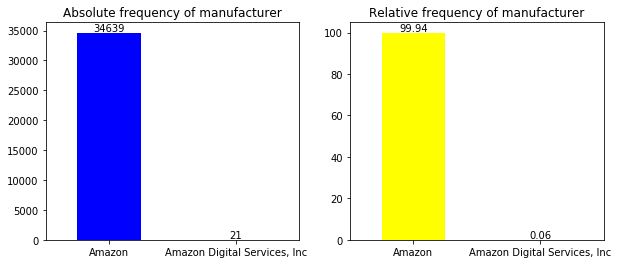

In [5]:
print("Nasa baza ima {} instanci\n".format(data.shape[0]))
print ("Atribut {} ima {} NaN vrednosti:".format(data['reviews.didPurchase'].name,data['reviews.didPurchase'].isna().sum()))
print ("Atribut {} ima {} NaN vrednosti:".format(data['reviews.id'].name,data['reviews.id'].isna().sum()))
print ("Atribut {} ima {} NaN vrednosti:".format(data['reviews.userCity'].name,data['reviews.userCity'].isna().sum()))
print ("Atribut {} ima {} NaN vrednosti:".format(data['reviews.userProvince'].name,data['reviews.userProvince'].isna().sum()))
print ("Atribut {} ima {} NaN vrednosti:".format(data['reviews.dateAdded'].name,data['reviews.dateAdded'].isna().sum()))
print("\nOve kolone cemo obrisati.")
print("\nAtribut keys predstavlja indekse izvora iz kojih se pravi ovaj dataset.\
      \nZa nas nebitna kolona, tako da i nju brisemo.\n")

plot_absolute_relative_frequency(data['manufacturer'])
print("Vidimo na bar plotu ispod da i atribut 'manufacturer' ima 99.94% jedan tip informacije,tako da i nju brisemo.")


data.drop(['reviews.didPurchase','reviews.id','reviews.userCity','reviews.userProvince','reviews.dateAdded','keys','manufacturer'], 
          axis=1, inplace=True)

In [10]:
print(f'Nakon brisanja, nasa baza ima {len(data.columns)} atributa, sa imenima:\n')
print(data.columns)

Nakon brisanja, nasa baza ima 14 atributa, sa imenima:

Index(['id', 'name', 'asins', 'brand', 'categories', 'reviews.date',
       'reviews.dateSeen', 'reviews.doRecommend', 'reviews.numHelpful',
       'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.username'],
      dtype='object')


In [11]:
data.dtypes

id                      object
name                    object
asins                   object
brand                   object
categories              object
reviews.date            object
reviews.dateSeen        object
reviews.doRecommend     object
reviews.numHelpful     float64
reviews.rating         float64
reviews.sourceURLs      object
reviews.text            object
reviews.title           object
reviews.username        object
dtype: object

In [12]:
data.describe()

,reviews.numHelpful,reviews.rating
count,34131.000000,34627.000000
mean,0.630248,4.584573
std,13.215775,0.735653
min,0.000000,1.000000
25%,0.000000,4.000000
50%,0.000000,5.000000
75%,0.000000,5.000000
max,814.000000,5.000000


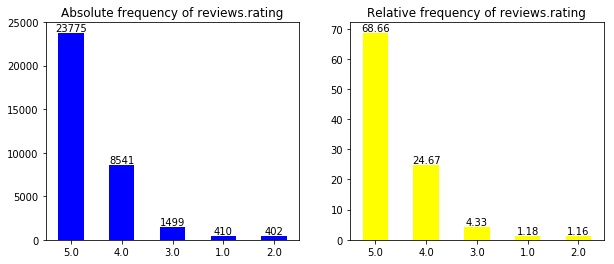

In [13]:
plot_absolute_relative_frequency(data['reviews.rating'])

Vidimo da u bazi dominiraju dobre ocene (4,5)

Sada ćemo da predstavimo kako su hronološki dodavane recenzije.

Novi tip datuma nije pandas vec <class 'datetime.date'>, pa lakse sredjujemo datum
Ima 39 NaN vrednosti u ovoj koloni
Ima 1045 razlicitih vrednosti u ovoj koloni
2017-01-16    710
2015-12-28    671
2017-01-23    657
2017-01-06    642
Name: reviews.date, dtype: int64


Text(0.5, 0, 'Vreme')

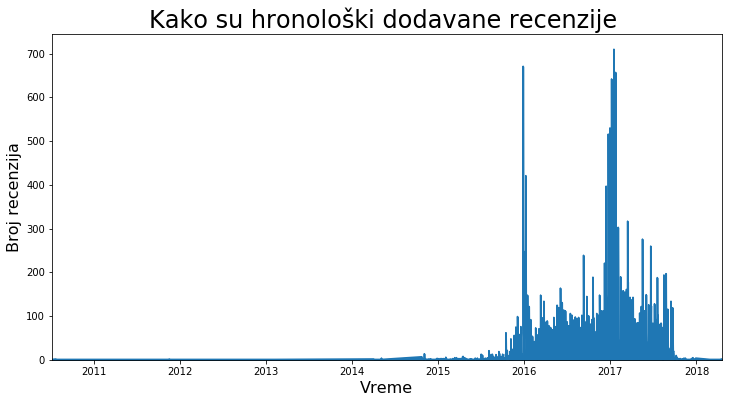

In [14]:
reviewsdate = pd.to_datetime(data['reviews.date']).dt.date #datum kada je ovaj review dodat
print(f'Novi tip datuma nije pandas vec {type(reviewsdate[0])}, pa lakse sredjujemo datum')
print (f'Ima {reviewsdate.isna().sum()} NaN vrednosti u ovoj koloni')
print(f'Ima {len(reviewsdate.value_counts())} razlicitih vrednosti u ovoj koloni')
print(reviewsdate.value_counts()[:4])
data['reviews.date'] = reviewsdate

RD_plot = reviewsdate.value_counts()
RD_plot.sort_index(inplace=True)
RD_plot.plot(kind='area',figsize=(12,6))
plt.title("Kako su hronološki dodavane recenzije ", fontdict={'fontsize':24})
plt.ylabel("Broj recenzija", fontdict={'fontsize':16})
plt.xlabel("Vreme", fontdict={'fontsize':16})

Text(0.5, 1.0, 'Dužina recenzije u odnosu na rejting')

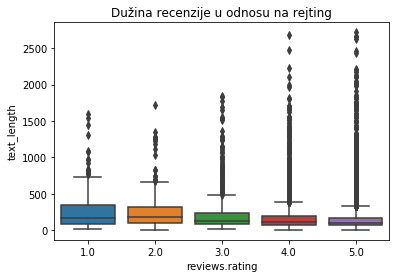

In [15]:
import seaborn as sns
data['text_length'] = data['reviews.text'].apply(lambda x: len(str(x))) #dodamo kolonu sa duzinom komentara

data1 = data[data['text_length']<3000]  # da izbacimo bas velike autlajere
sns.boxplot(x='reviews.rating', y='text_length',data=data1).set_title("Dužina recenzije u odnosu na rejting")


Vidimo da su komentari duži kod onih sa lošijim ocenama, ali zato više ocene imaju više autlajera(jer imaju i više tekstova generalno).

Zanemarićemo sve kolone osim rejtinga i teksta recenzije i pokušaćemo na osnovu teksta da zaključimo da li je recenzija pozitivna ili negativna.

In [5]:
currently = data[['reviews.text','reviews.rating']]
print("Broj NaN vrednosti po kolonama: \n")
print(currently.isnull().sum())
print(currently.head(3))

Broj NaN vrednosti po kolonama: 

reviews.text       1
reviews.rating    33
dtype: int64
                                        reviews.text  reviews.rating
0  This product so far has not disappointed. My c...             5.0
1  great for beginner or experienced person. Boug...             5.0
2  Inexpensive tablet for him to use and learn on...             5.0


In [6]:
print('Redovi sa NaN vrednostima, koje cemo izbaciti su:\n')
print(currently[currently["reviews.text"].isnull()].head())
print(currently[currently["reviews.rating"].isnull()].head(3))

Redovi sa NaN vrednostima, koje cemo izbaciti su:

     reviews.text  reviews.rating
3111          NaN             5.0
                                           reviews.text  reviews.rating
2886  The Kindle is my first e-ink reader. I own an ...             NaN
2887  I'm a first-time Kindle owner, so I have nothi...             NaN
2888  UPDATE NOVEMBER 2011:My review is now over a y...             NaN


In [7]:
reduced = currently.dropna(how='any') # Brisemo svaki red koji ima bilo gde NaN vrednost
print(f'Nakon brisanja imamo {reduced.shape[0]} instanci')

Nakon brisanja imamo 34626 instanci


In [8]:
print('Tekstove ocenjene sa 1,2,3 prepoznavacemo kao negativan sentiment')
print('A tekstove ocenjene sa 4,5 prepoznavacemo kao pozitivan sentiment\n')
print(reduced["reviews.rating"].unique())
reduced = reduced.replace([1,2,3], 0)
reduced = reduced.replace([4,5], 1)
print(reduced["reviews.rating"].unique())

Tekstove ocenjene sa 1,2,3 prepoznavacemo kao negativan sentiment
A tekstove ocenjene sa 4,5 prepoznavacemo kao pozitivan sentiment

[5. 4. 2. 1. 3.]
[1. 0.]


### Vizualizacija najčešćih reči kod pozitivnih i negativnih komenatara

In [20]:
reduced_neg = reduced[reduced["reviews.rating"]==0]
neg_text = []
for line in reduced_neg['reviews.text']:
    neg_text.append(line)  # Izvlacimo tekstove sa negativnim sentimentom

reduced_pos = reduced[reduced["reviews.rating"]==1]
pos_text = []
for line in reduced_pos['reviews.text']:
    pos_text.append(line)  # Izvlacimo tekstove sa pozitivnim sentimentom

In [21]:
from wordcloud import WordCloud # Biblioteka za vizualni prikaz najfrekvetnijih reci

In [22]:
stop_words = list(stopwords.words("english"))

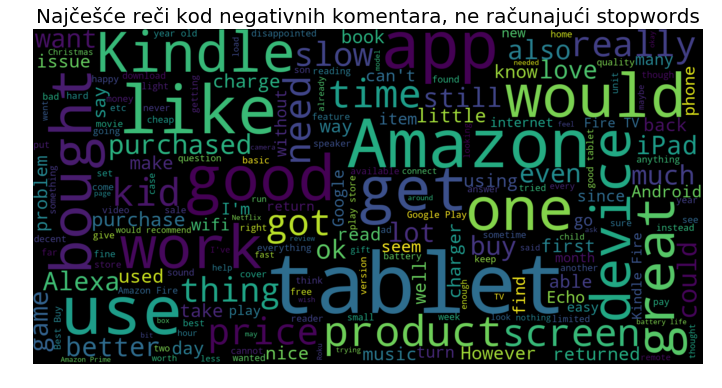

In [23]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, stopwords=stop_words).generate(str(neg_text))
plt.figure(figsize=(12,10))
plt.title('Najčešće reči kod negativnih komentara, ne računajući stopwords',fontdict={'fontsize':20})
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

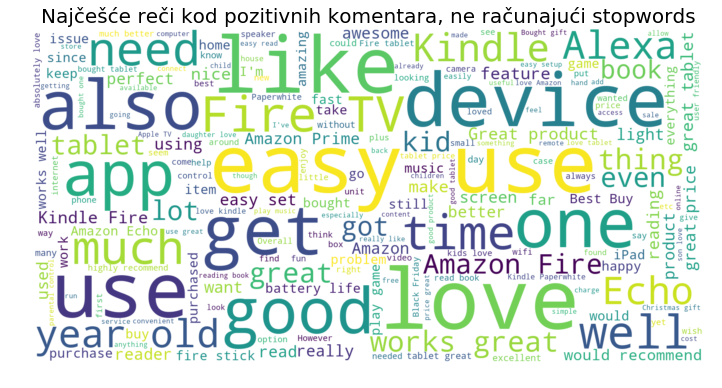

In [24]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, stopwords=stop_words, background_color='white').generate(str(pos_text))
plt.figure(figsize=(12,10))
plt.title('Najčešće reči kod pozitivnih komentara, ne računajući stopwords',fontdict={'fontsize':20})
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [9]:
x_bigram = reduced["reviews.text"]
y_bigram = reduced["reviews.rating"]

# Ovo smo izdvojili jer posle koristimo algoritam gde nam nije u interesu da pretprocesiramo tekst..

Prvo cemo pretprocesirati tekst za dalju upotrebu, smanjiti slova, zadrzati samo slova, svesti na koren reci, ukloniti nepotrebne reci..

In [10]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

#smanji sva slova
reduced["reviews.text"] = reduced["reviews.text"].str.lower() 
#tokenization of words
reduced['reviews.text'] = reduced.apply(lambda row: word_tokenize(row['reviews.text']), axis=1) 
#only alphanumerical values
reduced["reviews.text"] = reduced['reviews.text'].apply(lambda x: [item for item in x if item.isalpha()]) 
#lemmatazing words
reduced['reviews.text'] = reduced['reviews.text'].apply(lambda x : [WordNetLemmatizer().lemmatize(y) for y in x])
#removing useless words
stop = stopwords.words('english')
reduced['reviews.text'] = reduced['reviews.text'].apply(lambda x: [item for item in x if item not in stop])

In [11]:
from collections import Counter
my_counter = Counter()
for word in reduced['reviews.text']:
    my_counter.update(word)
print(f'Nakon pretprocesiranja, {len(my_counter.keys())} razlicitih reci imamo u korpusu') 

Nakon pretprocesiranja, 11691 razlicitih reci imamo u korpusu


In [13]:
x = reduced["reviews.text"]
y = reduced["reviews.rating"]

In [14]:
print(x.shape, y.shape)

(34626,) (34626,)


CountVectorizer, TfIdf ne primaju listu liste reci, pa cemo transformisati to u listu recenica...

In [15]:
x1 = []
for row in x:
    str11 = ' '.join(row)
    x1.append(str11)
x=x1

Podela na trening-test skup

In [16]:
 x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.33, random_state=42, stratify=y)

In [18]:
print(f'Dimenzije trening skupa: ({len(x_train)},{len(y_train)})')
print(f'Dimenzije test skupa: ({len(x_test)},{len(y_test)})')

Dimenzije trening skupa: (23199,23199)
Dimenzije test skupa: (11427,11427)


Text(0.5, 1.0, 'Podela podataka na trening,validacioni i test skup')

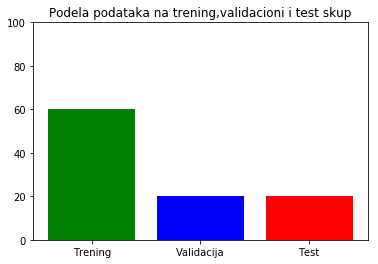

In [25]:
x_train_validation, x_test_v, y_train_validation, y_test_v =\
    model_selection.train_test_split(x, y, train_size = 0.8, test_size=0.2, stratify = y, random_state = 42)

x_train_v, x_validation, y_train_v, y_validation =\
    model_selection.train_test_split(x_train_validation, y_train_validation, train_size = 0.75, test_size = 0.25, stratify = y_train_validation, random_state = 42)

n = len(x)
n_trening = len(x_train_v )/ n * 100
n_val = len(x_validation) / n * 100
n_test = len(x_test_v) / n * 100

plt.bar(['Trening', 'Validacija', 'Test'],[n_trening, n_val, n_test], color=('green','blue','red'))
plt.ylim([0, 100])
plt.title('Podela podataka na trening,validacioni i test skup')

## CountVectorizer

<br>
Racunar se ne snalazi sa sirovim tekstom, pa je cilj da mu prosledimo neke smislene brojeve koji predstavljaju taj tekst.

CountVect pretvara korpus reci u matricu vektora. 

Prvo se napravi vokabular reci, zatim se reci redom poredjaju i dodeli im se redni broj. 

Recenica se predstavlja kao vektor dimenzije vokabulara, tako sto je i-ta koordinata 1 ukoliko je i-ta rec vokabulara prisutna u recenici, a 0 inace.

In [26]:
count_vectorizer = feature_extraction.text.CountVectorizer()
count_vectorizer.fit(x)

x_train_v_CountVect = count_vectorizer.transform(x_train_v)
x_validation_CountVect = count_vectorizer.transform(x_validation)
x_train_validation_CountVect = count_vectorizer.transform(x_train_validation)
x_test_v_CountVect = count_vectorizer.transform(x_test_v)

x_train_CountVect = count_vectorizer.transform(x_train)
x_test_CountVect = count_vectorizer.transform(x_test)
print('U trening skupu imamo {} recenica sa ukupno {} reci u njima'.format(x_train_CountVect.shape[0], x_train_CountVect.shape[1]))
print('U test skupu imamo {} recenica sa ukupno {} reci u njima'.format(x_test_CountVect.shape[0], x_test_CountVect.shape[1]))

U trening skupu imamo 23199 recenica sa ukupno 11675 reci u njima
U test skupu imamo 11427 recenica sa ukupno 11675 reci u njima


In [29]:
print('Neke od reci u podacima su npr: {}'.format(count_vectorizer.get_feature_names()[2200:2204]))

Neke od reci u podacima su npr: ['contestant', 'context', 'continent', 'contingency']


#### Napravicemo funkciju za obucavanje modela i za ispis ocena modela.

In [14]:
def train(name,model,x_train,y_train,x_test,y_test):
    start = time.time()

    model.fit(x_train, y_train)

    end = time.time()
    print('Vreme obucavanja je {0:.2f} minuta'.format((end - start)/60))
    
    y_test_predicted = model.predict(x_test)
    y_train_predicted = model.predict(x_train)

    ## Izracunava verovatnocu moguceg izlaza za uzorak iz X-a.
    y_train_predicted_prob = model.predict_proba(x_train)
    y_test_predicted_prob = model.predict_proba(x_test)
    
    model_train_score = model.score(x_train, y_train)
    print("Train {} score: {:.2%}".format(name,model_train_score))
    model_test_score = model.score(x_test, y_test)
    print("Test {} score: {:.2%}".format(name,model_test_score))
    ROC_train = metrics.roc_auc_score(y_train, y_train_predicted_prob[:,1])
    ROC_test = metrics.roc_auc_score(y_test, y_test_predicted_prob[:,1])
    print('ROC train curve: {:.2%}'.format(ROC_train))
    print('ROC test curve: {:.2%}'.format(ROC_test))
    print('Train acc: {:.2%}, Test acc: {:.2%}'.format(metrics.accuracy_score(y_train, y_train_predicted),metrics.accuracy_score(y_test, y_test_predicted)))
    print('\nConfusion matrix:\n{}'.format(metrics.confusion_matrix(y_test, y_test_predicted)))
    print('\nClassification report:\n{}'.format(metrics.classification_report(y_test, y_test_predicted)))

## Linear SVM - CountVect


In [37]:
model=svm.SVC(kernel='linear', probability=True)
name='Linear SVM with CountVectorizer'
train(name, model, x_train_CountVect, y_train, x_test_CountVect, y_test)

Vreme obucavanja je 3.36 minuta
Train Linear SVM with CountVectorizer score: 97.34%
Test Linear SVM with CountVectorizer score: 93.44%
ROC train curve: 95.24%
ROC test curve: 82.39%
Train acc: 97.34%, Test acc: 93.44%

Confusion matrix:
[[  222   541]
 [  209 10455]]

Classification report:
              precision    recall  f1-score   support

         0.0       0.52      0.29      0.37       763
         1.0       0.95      0.98      0.97     10664

   micro avg       0.93      0.93      0.93     11427
   macro avg       0.73      0.64      0.67     11427
weighted avg       0.92      0.93      0.93     11427



$$
\begin{bmatrix}
 222& 541 \\
209 & 10455
\end{bmatrix}$$

Weighted average se racuna npr za precision: (0.52 x (udeo klase 0 u ukupnom skupu) + 0.95 x (udeo klase 1 u ukupnom skupu))/2

Razlika izmedju micro avg i macro avg

Class A: 1 TP and 1 FP
Class B: 10 TP and 90 FP
Class C: 1 TP and 1 FP
Class D: 1 TP and 1 FP 
<br>
Vidimo da je PrA=PrC=PrD=0.5, whereas PrB=0.1.


Macro-average se onda racuna na sledeci nacin: Pr = (0.5+0.1+0.5+0.5)/4 = 0.4
Dok se micro-average racuna kao: Pr = (1+10+1+1)/(2+100+2+2) = 0.123

# TF-IDF Vectorizer (Term Frequency - Inverse Document Frequency)

Tf-idf predstavlja meru vaznosti reci u tekstu. Pretpostavljamo da je rec vaznija sto se vise puta ponavlja, medjutim neke reci poput if, do, but se prilicno cesto pojavljuju u tekstovima pa nam ne pomazu u odredjivanju sentimenta, zbog toga tf-idf mera daje vecu vaznost recima koje su specificne za deo teksta u odnosu na ceo dokument.

In [38]:
tf_idf_vectorizer = feature_extraction.text.TfidfVectorizer()
tf_idf_vectorizer.fit(x)

x_train_v_tfidf = tf_idf_vectorizer.transform(x_train_v)
x_validation_tfidf = tf_idf_vectorizer.transform(x_validation)
x_train_validation_tfidf = tf_idf_vectorizer.transform(x_train_validation)
x_test_v_tfidf = tf_idf_vectorizer.transform(x_test_v)

x_train_tfidf = tf_idf_vectorizer.transform(x_train)
x_test_tfidf = tf_idf_vectorizer.transform(x_test)

### Linear SVM - TF-IDF

In [39]:
model=svm.SVC(kernel='linear', probability=True)
name='Linear SVM with TF-IDF'
train(name,model,x_train_tfidf,y_train,x_test_tfidf,y_test)

Vreme obucavanja je 1.80 minuta
Train Linear SVM with TF-IDF score: 94.59%
Test Linear SVM with TF-IDF score: 93.80%
ROC train curve: 93.35%
ROC test curve: 85.68%
Train acc: 94.59%, Test acc: 93.80%

Confusion matrix:
[[   80   683]
 [   25 10639]]

Classification report:
              precision    recall  f1-score   support

         0.0       0.76      0.10      0.18       763
         1.0       0.94      1.00      0.97     10664

   micro avg       0.94      0.94      0.94     11427
   macro avg       0.85      0.55      0.58     11427
weighted avg       0.93      0.94      0.92     11427



TF-IDF naginje ka tome da su sve pozitivni komentari u odnosu na CountVect (sto se posebno vidi kod GridSerach-a), tako da iako TF-IDF ima bolju ROC vrednost i da se nesto brze obucava, u nastavku cemo koristiti CountVectorizer.

# GridSearchCV - trazenje najboljih parametara

In [40]:
grid_model = svm.SVC(kernel='rbf')
params = {'C': [10**i for i in range(-3, 3)], 'gamma': [10**i for i in range(-3, 3)]}
grid = model_selection.GridSearchCV(grid_model, param_grid=params, scoring='roc_auc')

In [41]:
start = time.time()

grid.fit(x_train_validation_CountVect, y_train_validation)

end = time.time()
print('Vreme obucavanja je {0:.2f} sati'.format((end - start)/3600))

C:\Users\vladimir.lukovic\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Vreme obucavanja je 5.14 sati


In [42]:
cv_results = pd.DataFrame(grid.cv_results_)
cv_results

C:\Users\vladimir.lukovic\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\vladimir.lukovic\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\vladimir.lukovic\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,8.035436,0.116909,3.237665,0.033548,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.797569,0.793586,0.781266,0.790807,0.006940,17,0.809540,0.819344,0.798740,0.809208,8.414660e-03
1,9.745007,0.135331,3.684322,0.130729,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.819330,0.816317,0.811062,0.815570,0.003417,16,0.868632,0.876253,0.866603,0.870496,4.154128e-03
2,11.799317,0.050243,4.638656,0.037801,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.771726,0.755578,0.766054,0.764453,0.006689,18,0.966082,0.961794,0.959311,0.962396,2.796925e-03
3,13.807955,0.464932,5.195147,0.095107,0.001,1,"{'C': 0.001, 'gamma': 1}",0.635718,0.641689,0.657868,0.645091,0.009358,24,1.000000,0.999306,0.998597,0.999301,5.726095e-04
4,12.955930,0.062738,4.910536,0.030752,0.001,10,"{'C': 0.001, 'gamma': 10}",0.504826,0.510082,0.506549,0.507152,0.002188,30,1.000000,0.999305,0.999190,0.999498,3.578112e-04
5,16.119242,0.092009,6.061100,0.032885,0.001,100,"{'C': 0.001, 'gamma': 100}",0.501563,0.503070,0.502317,0.502317,0.000615,36,1.000000,0.999653,0.999653,0.999769,1.635700e-04
6,10.149620,0.494580,3.671223,0.048766,0.01,0.001,"{'C': 0.01, 'gamma': 0.001}",0.831896,0.842713,0.831602,0.835404,0.005170,11,0.877208,0.893355,0.881403,0.883989,6.840992e-03
7,14.939801,0.093082,5.234857,0.260939,0.01,0.01,"{'C': 0.01, 'gamma': 0.01}",0.848805,0.853241,0.850203,0.850750,0.001852,5,0.935224,0.940003,0.938167,0.937798,1.968331e-03
8,56.085052,0.720081,12.265856,0.099928,0.01,0.1,"{'C': 0.01, 'gamma': 0.1}",0.834974,0.827043,0.837833,0.833283,0.004564,12,0.994713,0.994692,0.995663,0.995022,4.530123e-04
9,104.246857,0.208795,26.370460,0.044438,0.01,1,"{'C': 0.01, 'gamma': 1}",0.693308,0.693917,0.704057,0.697094,0.004930,23,1.000000,0.999328,0.999325,0.999551,3.173861e-04


Best params: {'C': 1, 'gamma': 0.01}
Best ROC: 0.8546987254848264


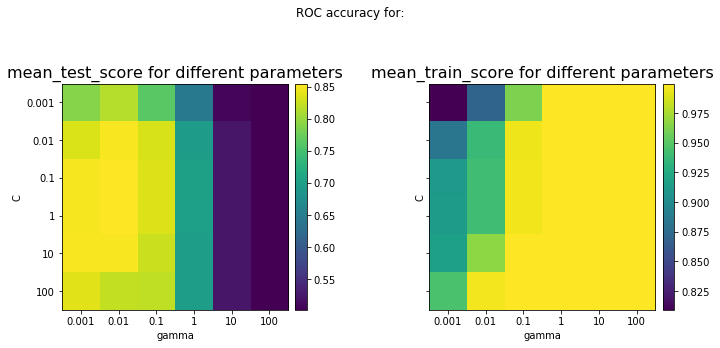

In [43]:
print(f'Best params: {grid.best_params_}')
print(f'Best ROC: {grid.best_score_}')

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,6))
fig.suptitle('ROC accuracy for:', fontdict={'fontsize':20})
cv_test_score = cv_results['mean_test_score'].values.reshape(6, 6)
cv_train_score = cv_results['mean_train_score'].values.reshape(6, 6)
ax1.set_title('mean_test_score for different parameters', fontdict={'fontsize':16})
ax2.set_title('mean_train_score for different parameters', fontdict={'fontsize':16})

ax1.set_xlabel('gamma')
ax2.set_xlabel('gamma')
ax1.set_ylabel('C')
ax2.set_ylabel('C')

plt.xticks(np.arange(0, 7), [10**i for i in range(-3, 3)])
plt.yticks(np.arange(0, 7), [10**i for i in range(-3, 3)])

im1 = ax1.imshow(cv_test_score, cmap='viridis', ) #
divider = make_axes_locatable(ax1)   # da se doda colorbar kod subplot-a
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = ax2.imshow(cv_train_score, cmap='viridis', )
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.subplots_adjust(top=1, bottom=0.08, left=0.10, right=0.95, wspace=0.5) # da se razmaknu subplot-ovi

## SVM(kernel='rbf') - pomocu nadjenih parametara

### GridSearch - Obucavanje pomocu CountVect


In [64]:
model=svm.SVC(kernel='rbf', C=1, gamma=0.01,  probability=True)
name='Gaussian SVM with CountVectorizer based on GridSearch parameters'
train(name,model,x_train_validation_CountVect,y_train_validation,x_test_v_CountVect,y_test_v)

Vreme obucavanja je 3.91 minuta
Train Gaussian SVM with CountVectorizer based on GridSearch parameters score: 93.66%
Test Gaussian SVM with CountVectorizer based on GridSearch parameters score: 93.33%
ROC train curve: 93.61%
ROC test curve: 85.98%
Train acc: 93.66%, Test acc: 93.33%

Confusion matrix:
[[   0  462]
 [   0 6464]]

Classification report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       462
         1.0       0.93      1.00      0.97      6464

   micro avg       0.93      0.93      0.93      6926
   macro avg       0.47      0.50      0.48      6926
weighted avg       0.87      0.93      0.90      6926



C:\Users\vladimir.lukovic\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Model sve klasifikuje kao pozitivne recenzije. Probacemo sa C=10, jer je izgleda doslo do preprilagodjavanja, a tacnost za C=10 je veoma slicna

In [18]:
model=svm.SVC(kernel='rbf', C=10, gamma=0.01,  probability=True)
name='Gaussian SVM with CountVectorizer based on GridSearch parameters'
train(name,model,x_train_validation_CountVect,y_train_validation,x_test_v_CountVect,y_test_v)

Vreme obucavanja je 6.45 minuta
Train Gaussian SVM with CountVectorizer based on GridSearch parameters score: 96.81%
Test Gaussian SVM with CountVectorizer based on GridSearch parameters score: 93.98%
ROC train curve: 96.47%
ROC test curve: 85.64%
Train acc: 96.81%, Test acc: 93.98%

Confusion matrix:
[[  97  365]
 [  52 6412]]

Classification report:
              precision    recall  f1-score   support

         0.0       0.65      0.21      0.32       462
         1.0       0.95      0.99      0.97      6464

   micro avg       0.94      0.94      0.94      6926
   macro avg       0.80      0.60      0.64      6926
weighted avg       0.93      0.94      0.93      6926



Ovo je malo bolje.

### GridSearch - Obucavanje pomocu TF-IDF

In [65]:
model=svm.SVC(kernel='rbf', C=1, gamma=0.01,  probability=True)
name='Gaussian SVM with CountVectorizer based on GridSearch parameters'
train(name,model,x_train_validation_tfidf,y_train_validation,x_test_v_tfidf,y_test_v)

Vreme obucavanja je 3.06 minuta
Train Gaussian SVM with CountVectorizer based on GridSearch parameters score: 93.32%
Test Gaussian SVM with CountVectorizer based on GridSearch parameters score: 93.33%
ROC train curve: 92.88%
ROC test curve: 85.77%
Train acc: 93.32%, Test acc: 93.33%

Confusion matrix:
[[   0  462]
 [   0 6464]]

Classification report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       462
         1.0       0.93      1.00      0.97      6464

   micro avg       0.93      0.93      0.93      6926
   macro avg       0.47      0.50      0.48      6926
weighted avg       0.87      0.93      0.90      6926



C:\Users\vladimir.lukovic\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


TF-IDF je isto predvideo da su sve pozitivni komentari, sto je potpuno neupotrebljiv model. Iako je dobar ROC, veoma je los princip. Zakljucujemo da je bolje koristiti CountVectorizer, situacija je ista i kad se isproba sa C=10.

## GridSearchCV - dalje (finije) trazenje najboljih parametara

In [46]:
grid_model = svm.SVC(kernel='rbf')
params = {'C': [10**i for i in range(-3, 3)], 'gamma': [10**i for i in range(-6, 0)]}
grid = model_selection.GridSearchCV(grid_model, param_grid=params, scoring='roc_auc')

In [47]:
start = time.time()

grid.fit(x_train_validation_CountVect, y_train_validation)

end = time.time()
print('Vreme obucavanja je {0:.2f} sata'.format((end - start)/3600))

C:\Users\vladimir.lukovic\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Vreme obucavanja je 1.28 sata


In [48]:
grid.best_params_

{'C': 1, 'gamma': 0.01}

In [49]:
cv_results = pd.DataFrame(grid.cv_results_)
cv_results

C:\Users\vladimir.lukovic\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\vladimir.lukovic\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\vladimir.lukovic\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,6.900535,0.028889,2.842611,0.013985,0.001,1e-06,"{'C': 0.001, 'gamma': 1e-06}",0.668110,0.672542,0.678661,0.673104,0.004326,34,0.676495,0.688899,0.670420,0.678605,7.690007e-03
1,6.929771,0.044294,2.855652,0.013166,0.001,1e-05,"{'C': 0.001, 'gamma': 1e-05}",0.667265,0.672600,0.677603,0.672489,0.004222,36,0.675877,0.688559,0.669405,0.677947,7.955445e-03
2,7.346322,0.188242,3.020119,0.076574,0.001,0.0001,"{'C': 0.001, 'gamma': 0.0001}",0.736563,0.739339,0.696106,0.724003,0.019758,33,0.744280,0.758410,0.692941,0.731877,2.812985e-02
3,8.187475,0.249914,3.230178,0.030056,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.797569,0.793586,0.781266,0.790807,0.006940,29,0.809540,0.819344,0.798740,0.809208,8.414660e-03
4,9.748347,0.080518,3.596368,0.027458,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.819330,0.816317,0.811062,0.815570,0.003417,26,0.868632,0.876253,0.866603,0.870496,4.154128e-03
5,11.886359,0.096588,4.639515,0.030841,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.771726,0.755578,0.766054,0.764453,0.006689,30,0.966082,0.961794,0.959311,0.962396,2.796925e-03
6,6.920360,0.012538,2.834505,0.012636,0.01,1e-06,"{'C': 0.01, 'gamma': 1e-06}",0.667852,0.671635,0.678026,0.672504,0.004199,35,0.676411,0.687959,0.669940,0.678103,7.453000e-03
7,7.414003,0.258251,3.042486,0.093767,0.01,1e-05,"{'C': 0.01, 'gamma': 1e-05}",0.752795,0.760995,0.696285,0.736692,0.028767,32,0.760860,0.781278,0.693083,0.745073,3.769625e-02
8,8.211296,0.034793,3.237909,0.034531,0.01,0.0001,"{'C': 0.01, 'gamma': 0.0001}",0.809334,0.813183,0.810012,0.810843,0.001678,27,0.827452,0.839115,0.832305,0.832957,4.783607e-03
9,10.398298,0.435049,3.632658,0.054332,0.01,0.001,"{'C': 0.01, 'gamma': 0.001}",0.831896,0.842713,0.831602,0.835404,0.005170,17,0.877208,0.893355,0.881403,0.883989,6.840992e-03


Best params: {'C': 1, 'gamma': 0.01}
Best score: 0.8546987254848264


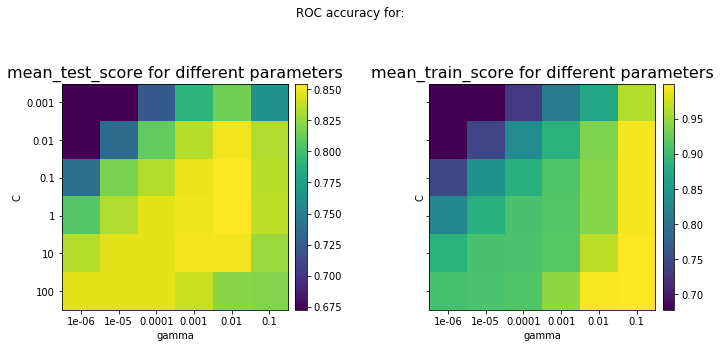

In [50]:
print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,6))
fig.suptitle('ROC accuracy for:', fontdict={'fontsize':20})
cv_test_score = cv_results['mean_test_score'].values.reshape(6, 6)
cv_train_score = cv_results['mean_train_score'].values.reshape(6, 6)
ax1.set_title('mean_test_score for different parameters', fontdict={'fontsize':16})
ax2.set_title('mean_train_score for different parameters', fontdict={'fontsize':16})

ax1.set_xlabel('gamma')
ax2.set_xlabel('gamma')
ax1.set_ylabel('C')
ax2.set_ylabel('C')

plt.xticks(np.arange(0, 7), [10**i for i in range(-6, 0)])
plt.yticks(np.arange(0, 7), [10**i for i in range(-3, 3)])

im1 = ax1.imshow(cv_test_score, cmap='viridis', ) #
divider = make_axes_locatable(ax1)   # da se doda colorbar kod subplot-a
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = ax2.imshow(cv_train_score, cmap='viridis', )
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.subplots_adjust(top=1, bottom=0.08, left=0.10, right=0.95, wspace=0.5) # da se razmaknu subplot-ovi

Vidimo da je promenom mogucih vrednosti za parametre u GridSearch-u, opet dobio da su najbolji {'C':1, 'gamma':0.01}.

To nam govori da daljim, finijim trazenjem parametara dolazimo do preprilagodjavanja, a ranijim odustajanjem gubimo na tacnosti. 

Za ove parametre smo vec ranije obucili SVM model i zakljucili da koristimo CountVect algoritam, ne TF-IDF.

# Multinomial Naive Bayes

Multinomial Naive Bayes predstavlja modifikaciju Bajesovog algoritma za višedimenzione raspodele.
Često koristi u klasifikaciji teksta kada su podaci predstavljeni pomocu CountVect, TF-IDF.

Raspodela je predstavljena vektorom $\theta_{y}=(\theta_{y_1},...,\theta_{y_n})$ za svaku klasu $y$ gde je $n$ ukupan broj reci, a $\theta_{y_i}$ predstavlja verovatnocu $P(x_i|y)$ da se rec $i$ pojavljuje u klasi $y$.

Poznato je da kod Bajesovog algoritma može doći često do množenja verovatnoća nulom, zbog čega uvodimo regularizacioni parametar $\alpha$.

Parametar $\theta_{y_i}$ se ocenjuje relativnom frekvencijom pojavljivanja reci i u klasi $y$, modifikovanom parametrom $\alpha$.
$$\hat{\theta_{y_i}}=\frac{N_{y_i}+\alpha}{N_y+\alpha n}$$

Regularizacioni parametar kod MNB $\alpha$ se naziva Laplas/Lidstone regularizacioni parametar. 
Razmislimo kako razlicite vrednosti $\alpha$ uticu na verovatnoce. Podrazumevana vrednost je 1, a Ako je $\alpha=0$, znači da nema regularizacije te nam se mogu pojaviti verovatnoce 0, dok velike vrednosti $\alpha$ umanjuju znacaj relativne frekvencije i vode ka uniformnoj raspodeli.

Prvo ćemo pomoću trening i validacionog skupa naci najbolji regularizacioni parametar $\alpha$ i onda ceo model obučiti i testirati na test skupu.

In [29]:
prediction = {} # ovde cemo cuvati previdjene verovatnoce, da bismo na kraju iscrtali kako uce ROC krive..

In [37]:
best_ROC = 0
best_alpha = None

alphas = [i/10 for i in range(10)]
zero = np.zeros(10)
ROC_dict = {}
for a, z in zip(alphas,zero):
    ROC_dict[a] = z

In [38]:
start = time.time()

for alpha in alphas:  # idemo redom za svaki parametar i racunamo ROC..
    nb_multinomial_model = MultinomialNB(alpha=alpha)
    nb_multinomial_model.fit(x_train_v_CountVect, y_train_v)

    y_probabilities_predicted = nb_multinomial_model.predict_proba(x_validation_CountVect)
    ROC = metrics.roc_auc_score(y_validation, y_probabilities_predicted[:,1])
    
    if ROC>best_ROC:
        best_ROC = ROC
        best_alpha = alpha
    ROC_dict[alpha] = ROC # samo da bi ispisao na 3 decimale

print('Vrednosti ROC-a za svaki parametar pojedinacno: \n{}\n'.format(ROC_dict))
print('Najbolje alpha je: {} i postize se ROC vrednost: {}'.format(best_alpha,best_ROC))

end = time.time()
print('\nVreme obucavanja je {0:.2f} sekundi.'.format((end - start)))
print('\nPrednost ovog alogritma je sto se veoma brzo obucava, jednostavan je, a daje dobre rezultate.')

Vrednosti ROC-a za svaki parametar pojedinacno: 
{0.0: 0.6417928092846862, 0.1: 0.8579550059512925, 0.2: 0.8618985326396744, 0.3: 0.8621520570305965, 0.4: 0.8608439113622466, 0.5: 0.858502913353602, 0.6: 0.8550339494947261, 0.7: 0.8507397754651352, 0.8: 0.8457649035167215, 0.9: 0.840471200365986}

Najbolje alpha je: 0.3 i postize se ROC vrednost: 0.8621520570305965

Vreme obucavanja je 0.14 sekundi.

Prednost ovog alogritma je sto se veoma brzo obucava, jednostavan je, a daje dobre rezultate.


C:\Users\Vlada\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Obucavamo na celom trening-validacionom skupu

In [40]:
model = MultinomialNB(alpha=0.3) # moze i alpha = 0.2
name="Multinomial Naive Bayes"
train(name,model,x_train_validation_CountVect,y_train_validation,x_test_v_CountVect,y_test_v)
y_probabilities_predicted = model.predict_proba(x_test_v_CountVect)
prediction['Multinomial'] = y_probabilities_predicted[:,1]

Vreme obucavanja je 0.00 minuta
Train Multinomial Naive Bayes score: 94.77%
Test Multinomial Naive Bayes score: 92.55%
ROC train curve: 92.07%
ROC test curve: 87.76%
Train acc: 94.77%, Test acc: 92.55%

Confusion matrix:
[[ 213  249]
 [ 267 6197]]

Classification report:
              precision    recall  f1-score   support

         0.0       0.44      0.46      0.45       462
         1.0       0.96      0.96      0.96      6464

   micro avg       0.93      0.93      0.93      6926
   macro avg       0.70      0.71      0.71      6926
weighted avg       0.93      0.93      0.93      6926



Potvrdilo se da je koriscenje ovog algoritma veoma prakticno. Daje veoma dobre rezultate uz jednostavnu arhitekturu i dobru brzinu izvrsavanja.

## Complement Naive Bayes

Complement Naive Bayes (CNB) je standarni MNB prilagodjen nebalansiranom setu podataka (poput naseg). 
CNB koristi kompement svake klase za racunanje tezine modela. 
CNB obicno pobedjuje MNB u problemima klasifikacije teksta.
Procedura za racunanje tezina je sledeca:
$$\hat{\theta_{c_i}}=\frac{\alpha_i+\sum_{j:y_j\ne c}{d_{ij}}}{\alpha+\sum_{j:y_j\ne c}{\sum_k {d_{kj}}}}$$
$$w_{c_i}=\frac{log(\hat{\theta_{c_i}})}{\sum_j{|log(\hat{\theta_{c_j}})|}}$$

Gde $d_{ij}$ predstavlja TF-IDF tezinu reci $i$ u dokumentu $j$.Druga normalizacija resava problem MNB-a koji tezi tome da duzim tekstovima daje vecu znacajnost.
Pravilo klasifikacije je :
$$\hat{c}={argmin}_c \sum_i {t_i w_{c_i}}$$
Odnosno, dokument se dodeljuje onoj klasi koja ima najmanji komplement. Kod MNB-a smo dokument dodeljivali klasi koja ima najvecu verovatnocu, sada dodeljujemo klasi koja ima najmanji stepen "neslaganja".


In [41]:
best_ROC = 0
best_alpha = None

alphas = [i/10 for i in range(10)]
zero = np.zeros(10)
ROC_dict = {}
for alpha, z in zip(alphas,zero):
    ROC_dict[alpha] = z   # Samo pravimo recnik gde cemo za svaku alpha upisati vrednost ROC-a

In [42]:
start = time.time()

for alpha in alphas:  # idemo redom za svaki parametar i racunamo ROC..
    nb_complement_model = ComplementNB(alpha=alpha)
    nb_complement_model.fit(x_train_v_CountVect, y_train_v)

    y_probabilities_predicted = nb_complement_model.predict_proba(x_validation_CountVect)
    ROC = metrics.roc_auc_score(y_validation, y_probabilities_predicted[:,1])
    
    if ROC>best_ROC:
        best_ROC = ROC
        best_alpha = alpha
    ROC_dict[alpha] = '%.3f'%(ROC) # samo da bi ispisao na 3 decimale

    
print(f'Vrednosti ROC-a za svaki parametar pojedinacno: \n{ROC_dict}\n')
print('Najbolje alpha je: {} i postize se ROC vrednost: {}'.format(best_alpha,best_ROC))

end = time.time()
print('\nVreme obucavanja je {0:.2f} sekundi.'.format((end - start)))

Vrednosti ROC-a za svaki parametar pojedinacno: 
{0.0: '0.641', 0.1: '0.858', 0.2: '0.862', 0.3: '0.862', 0.4: '0.861', 0.5: '0.859', 0.6: '0.855', 0.7: '0.851', 0.8: '0.846', 0.9: '0.840'}

Najbolje alpha je: 0.3 i postize se ROC vrednost: 0.8621520570305965

Vreme obucavanja je 0.14 sekundi.


C:\Users\Vlada\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [43]:
model = ComplementNB(alpha=0.3) 
name="Complement Naive Bayes"
train(name,model,x_train_validation_CountVect,y_train_validation,x_test_v_CountVect,y_test_v)
y_probabilities_predicted = model.predict_proba(x_test_v_CountVect)
prediction['Complement'] = y_probabilities_predicted[:,1]

Vreme obucavanja je 0.00 minuta
Train Complement Naive Bayes score: 89.29%
Test Complement Naive Bayes score: 86.28%
ROC train curve: 92.07%
ROC test curve: 87.76%
Train acc: 89.29%, Test acc: 86.28%

Confusion matrix:
[[ 329  133]
 [ 817 5647]]

Classification report:
              precision    recall  f1-score   support

         0.0       0.29      0.71      0.41       462
         1.0       0.98      0.87      0.92      6464

   micro avg       0.86      0.86      0.86      6926
   macro avg       0.63      0.79      0.67      6926
weighted avg       0.93      0.86      0.89      6926




Sasvim dobre rezultate dobijamo i pomocu CNB, malo su drugacije brojke u odnosu na MNB, ovde je recall veci, ali precision manji, kao i accuracy.


## Bernoulli Naive Bayes

Razlika izmedju MNB-a i BNB-a je u tome sto MNB radi sa frekvencijama reci, dok je BNB napravljen za binarne vektore.
Oba klasifikatora su primenljiva na  diskretne podatke.
Da bi se uverili da nama vise odgovara MNB, provericemo samo rezultate evaluacije za BNB koristeci isti parametar kao kod MNB.


In [44]:
model = BernoulliNB(alpha=0.2) 
name="Bernoulli Naive Bayes"
train(name,model,x_train_validation_CountVect,y_train_validation,x_test_v_CountVect,y_test_v)
y_probabilities_predicted = model.predict_proba(x_test_v_CountVect)
prediction['Bernoulli'] = y_probabilities_predicted[:,1]

Vreme obucavanja je 0.00 minuta
Train Bernoulli Naive Bayes score: 92.05%
Test Bernoulli Naive Bayes score: 89.97%
ROC train curve: 88.73%
ROC test curve: 84.29%
Train acc: 92.05%, Test acc: 89.97%

Confusion matrix:
[[ 197  265]
 [ 430 6034]]

Classification report:
              precision    recall  f1-score   support

         0.0       0.31      0.43      0.36       462
         1.0       0.96      0.93      0.95      6464

   micro avg       0.90      0.90      0.90      6926
   macro avg       0.64      0.68      0.65      6926
weighted avg       0.91      0.90      0.91      6926



Kao sto smo i pretpostavili, Multinomial Naive Bayes ipak daje bolje rezultate, iako i ovaj algoritam deluje veoma korisno kada imamo atribute u binarnom obliku.

### Vizualni prikaz za povrsine ispod ROC krive za MNB,CNB i BNB

Nacrtacemo ROC krive za MNB,CNB i BNB.

TPR(true positive rate) = TP / (TP+FN)

FPR(false positive rate) = FP / (TN+FP)

[Objasnjenje ROC krive](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

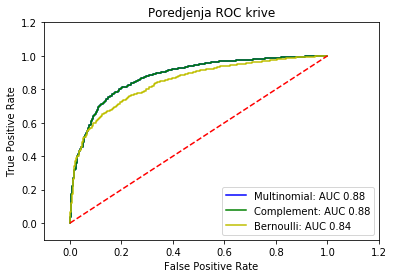

In [45]:
cmp = 0
colors = ['b', 'g', 'y']

for model_name, y_predictied_proba in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test_v, y_predictied_proba)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model_name,roc_auc))
    cmp += 1
    
plt.title('Poredjenja ROC krive')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Sa grafika se vidi da algoritmi MNB i CNB su veoma slicni, prakticno isto uce, dok je BNB za nijansu losiji jer nam atributi nisu u binarnom obliku

## KNN

Algoritam pronalazi k najblizih suseda i na osnovu njih klasifikuje instancu.

Metaparametar k cemo naci pomocu skupa za validaciju i testiranje.

In [60]:
k_range = range(2,15)
ROC_results = []
acc_results = []

In [61]:
start = time.time()

for k in k_range:
    knn_model = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(x_train_v_CountVect, y_train_v)
    
    y_predicted = knn_model.predict(x_validation_CountVect)
    acc = metrics.accuracy_score(y_validation, y_predicted)
    
    y_probabilities_predicted = knn_model.predict_proba(x_validation_CountVect)
    ROC = metrics.roc_auc_score(y_validation, y_probabilities_predicted[:,1])
    
    acc_results.append(round(acc,4))
    ROC_results.append(round(ROC,4))

for ROC,k,a in zip(ROC_results,k_range,acc_results):
    print(f"Za k={k}, ROC={ROC}, accuracy={a}")

end = time.time()
print(f'\nVreme izvrsavanja je: {round((end-start)/60,4)} minuta')

Za k=2, ROC=0.5692, accuracy=0.8722
Za k=3, ROC=0.5946, accuracy=0.9304
Za k=4, ROC=0.5908, accuracy=0.9277
Za k=5, ROC=0.5966, accuracy=0.9326
Za k=6, ROC=0.6039, accuracy=0.9327
Za k=7, ROC=0.6054, accuracy=0.9327
Za k=8, ROC=0.6051, accuracy=0.9329
Za k=9, ROC=0.6127, accuracy=0.9333
Za k=10, ROC=0.615, accuracy=0.9331
Za k=11, ROC=0.6164, accuracy=0.9333
Za k=12, ROC=0.6229, accuracy=0.9333
Za k=13, ROC=0.6275, accuracy=0.9333
Za k=14, ROC=0.629, accuracy=0.9333

Vreme izvrsavanja je: 2.3397 minuta


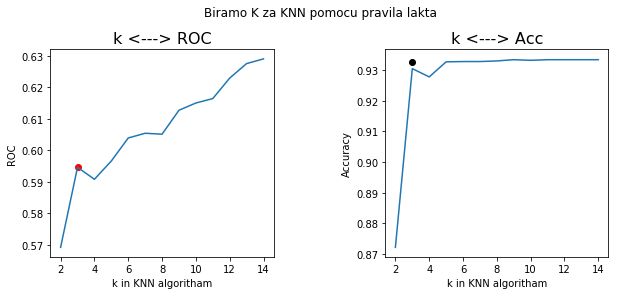

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10,6))
fig.suptitle('Biramo K za KNN pomocu pravila lakta', fontdict={'fontsize':20})

ax1.plot(k_range, ROC_results)
ax2.plot(k_range, acc_results)

ax1.set_xlabel('k in KNN algoritham')
ax2.set_xlabel('k in KNN algoritham')
ax1.set_ylabel('ROC')
ax2.set_ylabel('Accuracy')

ax1.set_title('k <---> ROC', fontdict={'fontsize':16})
ax2.set_title('k <---> Acc', fontdict={'fontsize':16})

plt.subplots_adjust(wspace=0.5, bottom=0.4)
ax1.scatter(3, ROC_results[1], c='red')
ax2.scatter(3, acc_results[3], c='black')

Pri biranju metaparametara k postoji "pravilo lakta".
Mi cemo izabati k=3.

In [66]:
model =  neighbors.KNeighborsClassifier(n_neighbors=3)
name='KNN'
train(name,model,x_train_validation_CountVect,y_train_validation,x_test_v_CountVect,y_test_v)

Vreme obucavanja je 0.00 minuta
Train KNN score: 94.58%
Test KNN score: 93.21%
ROC train curve: 96.85%
ROC test curve: 58.87%
Train acc: 94.58%, Test acc: 93.21%

Confusion matrix:
[[  17  445]
 [  25 6439]]

Classification report:
              precision    recall  f1-score   support

         0.0       0.40      0.04      0.07       462
         1.0       0.94      1.00      0.96      6464

   micro avg       0.93      0.93      0.93      6926
   macro avg       0.67      0.52      0.52      6926
weighted avg       0.90      0.93      0.90      6926



Vidimo da je KNN generalno los, uprkos score-u i acc-u, jer uglavnom sve komentare prognozira kao pozitivne, sto nam nista ne znaci.

Bolje su se pokazali SVM, Naive Bayes...

## SentiWordnet


SentiWordnet vraca za svaku rec iz engleskog positivni i negativni score.
Za svaki komentar, sabracemo pozitivne i oduzeti negativne skorove i videti da li je konacan rezultat veci od 0.


In [67]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('sentiwordnet')

from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag
 
lemmatizer = WordNetLemmatizer() 
 
def penn_to_wn(tag):
    """
    Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None
 
# def clean_text(text): 
#     text = text.replace("<br />", " ")
#     text = text.decode("utf-8")
 
#     return text
 
def swn_polarity(text):
    """
    Return a sentiment polarity: 0 = negative, 1 = positive
    """
    sentiment = 0.0
    tokens_count = 0
    
    #text = clean_text(text)

    raw_sentences = sent_tokenize(text)  # vraca listu recenica i svaka recenica ima listu reci (tokenize)
    for raw_sentence in raw_sentences:
        tagged_sentence = pos_tag(word_tokenize(raw_sentence)) # Nalazi da li je imenica, glagol, pridev, ...

        for word, tag in tagged_sentence:
            wn_tag = penn_to_wn(tag)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                continue

            lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            if not lemma:
                continue

            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                continue

            # Take the first sense, the most common
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())

            sentiment += swn_synset.pos_score() - swn_synset.neg_score()
            tokens_count += 1

    # judgment call ? Default to positive or negative
    if not tokens_count:
        return 0

    # sum greater than 0 => positive sentiment
    if sentiment >= 0:
        return 1

    # negative sentiment
    return 0

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\vladimir.lukovic\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vladimir.lukovic\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\vladimir.lukovic\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [68]:
start = time.time()

y_train_pred_swn = [swn_polarity(text) for text in x_train]
y_test_pred_swn = [swn_polarity(text) for text in x_test]
 
print('Train acc: {:.2%}, Test acc: {:.2%}'.format(metrics.accuracy_score(y_train, y_train_pred_swn),metrics.accuracy_score(y_test, y_test_pred_swn)))
print('\nMatrica konfuzije je:\n{}'.format(metrics.confusion_matrix(y_test, y_test_pred_swn)))
print('\nClassification report:\n{}'.format(metrics.classification_report(y_test, y_test_pred_swn)))

end = time.time()
print('Vreme obucavanja je {0:.2f} minuta'.format((end - start)/60))

Train acc: 85.24%, Test acc: 85.55%

Matrica konfuzije je:
[[ 163  600]
 [1051 9613]]

Classification report:
              precision    recall  f1-score   support

         0.0       0.13      0.21      0.16       763
         1.0       0.94      0.90      0.92     10664

   micro avg       0.86      0.86      0.86     11427
   macro avg       0.54      0.56      0.54     11427
weighted avg       0.89      0.86      0.87     11427

Vreme obucavanja je 1.52 minuta


Nema razlike izmedju trening i test skupa, jer se algoritam zapravo i ne obucava vec samo broji koliko je neki tekst pozitivan/negativan.
Brzo se izvrsava.

Iako rezultati i nisu nesto specijalno, sama ideja algoritma je veoma zanimljiva.

# Bigram classifier - Count Vectorizer

Posmatra kombinacije uzastopnih reči. Primenićemo na sirov tekst, bez uklanjanja stopwords i lementizovanja.


In [9]:
# x_bigram, y_bigram smo instancirali pre pretprocesiranja teksta ...

In [10]:
 x_train_b, x_test_b, y_train_b, y_test_b = model_selection.train_test_split(x_bigram, y_bigram, test_size=0.33, random_state=42, stratify=y_bigram)

In [12]:
from nltk.tokenize import word_tokenize
count_vectorizer_bigram = feature_extraction.text.CountVectorizer(analyzer="word",
                                                                  ngram_range=(2, 2),
                                                                  tokenizer=word_tokenize) #bigram classifier
count_vectorizer_bigram.fit(x_bigram)
x_train_CountVect_bigram = count_vectorizer_bigram.transform(x_train_b)
x_test_CountVect_bigram = count_vectorizer_bigram.transform(x_test_b)
print('U trening skupu imamo {} recenica sa ukupno {} reci u njima'.format(x_train_CountVect_bigram.shape[0], x_train_CountVect_bigram.shape[1]))
print('U test skupu imamo {} recenica sa ukupno {} reci u njima'.format(x_test_CountVect_bigram.shape[0], x_test_CountVect_bigram.shape[1]))

U trening skupu imamo 23199 recenica sa ukupno 186407 reci u njima
U test skupu imamo 11427 recenica sa ukupno 186407 reci u njima


In [15]:
model = svm.SVC(kernel='linear', probability=True)
name='SVM with bigram CountVectorizer'
train(name,model,x_train_CountVect_bigram,y_train_b,x_test_CountVect_bigram,y_test_b)

Vreme obucavanja je 17.31 minuta
Train SVM with bigram CountVectorizer score: 99.98%
Test SVM with bigram CountVectorizer score: 93.32%
ROC train curve: 100.00%
ROC test curve: 83.04%
Train acc: 99.98%, Test acc: 93.32%

Confusion matrix:
[[  234   529]
 [  234 10430]]

Classification report:
              precision    recall  f1-score   support

         0.0       0.50      0.31      0.38       763
         1.0       0.95      0.98      0.96     10664

   micro avg       0.93      0.93      0.93     11427
   macro avg       0.73      0.64      0.67     11427
weighted avg       0.92      0.93      0.93     11427



Dobijeni su dobri rezultati. Dolazimo do zakljucka da je ideja bigram-a znacajna metoda, koju svakako ne bi trebalo gubiti iz vida.

# LIGHTGBM

Light GBM je Microsoft-ov brzi, gradient boosting algoritam sa odlicnim performansama. Bazira se na stablu odlucivanja, bira se list sa najmanjim gubitkom da se na njemu nastavi stablo. Stoga se kaze da Light GBM raste vertikalno, dok stablo oducivanja raste horizontalno.

[LightGBM’s documentation!](https://lightgbm.readthedocs.io/en/latest/index.html)

[light-gbm-vs-xgboost](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/)

In [35]:
import lightgbm as lgb

lgb_train = lgb.Dataset(x_train_v_CountVect.astype(float), y_train_v)
lgb_validation = lgb.Dataset(x_validation_CountVect.astype(float), y_validation)

Podesavamo parametre za dati model

In [36]:
param = {
#     'bagging_freq': 5,
#     'bagging_fraction': 0.4,
    'boost_from_average':'false', # default = True(adjusts initial score to the mean of labels for faster convergence). 
                                  # moze i default
    'boost': 'goss',  #  Gradient-based One-Side Sampling
    'feature_fraction': 0.8,   # LightGBM will randomly select part of features on each iteration if feature_fraction smaller than 1.0. 
                               # For example, if you set it to 0.8, LightGBM will select 80% of features before training each tree
                               # Probao sam dosta vrednosti i cini se da za manje dolazi do preprilagodjavanja...
    'learning_rate': 0.01, # Learning rate controls how quickly or slowly a neural network model learns a problem.
                           # Usually is 0.01 or 0.1 
    'max_depth': -1,   # Importat parameters, it specifies the maximum depth or level up to which tree can grow.
    
    'metric':'auc',
    
    'min_data_in_leaf': 50, # It is also one of the important parameters in dealing with overfitting. 
                             # Setting its value smaller may cause overfitting and hence must be set accordingly.
                             # Its value should be hundreds to thousands of large datasets.
    'min_sum_hessian_in_leaf': 10.0,
    
    'num_leaves': 20,   # Theoretically num_leaves= 2^(max_depth)
    
    'num_threads': 8,   # Number of threads for LightGBM. 
                        # For the best speed, set this to the number of real CPU cores
    
    'tree_learner': 'voting', # default = serial
    'objective': 'binary',  # Requires labels in {0, 1}
    'verbosity': 1
}

In [37]:
start = time.time()

lgb_model = lgb.train(param, lgb_train, num_boost_round= 15000, valid_sets = lgb_validation, verbose_eval=100,
                early_stopping_rounds = 3000)  # early stopping is a form of regularization used to avoid overfitting.

end = time.time()
print('Vreme obucavanja je {0:.2f} minuta'.format((end - start)/60))

Training until validation scores don't improve for 3000 rounds.
[100]	valid_0's auc: 0.807559
[200]	valid_0's auc: 0.812991
[300]	valid_0's auc: 0.819799
[400]	valid_0's auc: 0.827498
[500]	valid_0's auc: 0.836479
[600]	valid_0's auc: 0.842324
[700]	valid_0's auc: 0.846067
[800]	valid_0's auc: 0.848437
[900]	valid_0's auc: 0.84952
[1000]	valid_0's auc: 0.850459
[1100]	valid_0's auc: 0.850755
[1200]	valid_0's auc: 0.851108
[1300]	valid_0's auc: 0.851204
[1400]	valid_0's auc: 0.850873
[1500]	valid_0's auc: 0.850825
[1600]	valid_0's auc: 0.850773
[1700]	valid_0's auc: 0.850477
[1800]	valid_0's auc: 0.850212
[1900]	valid_0's auc: 0.849864
[2000]	valid_0's auc: 0.84967
[2100]	valid_0's auc: 0.849512
[2200]	valid_0's auc: 0.849184
[2300]	valid_0's auc: 0.848792
[2400]	valid_0's auc: 0.848774
[2500]	valid_0's auc: 0.848977
[2600]	valid_0's auc: 0.848633
[2700]	valid_0's auc: 0.848534
[2800]	valid_0's auc: 0.848381
[2900]	valid_0's auc: 0.848195
[3000]	valid_0's auc: 0.848154
[3100]	valid_0's 

In [38]:
y_train_predicted = lgb_model.predict(x_train_validation_CountVect.astype(float), num_iteration=lgb_model.best_iteration)
y_test_predicted =  lgb_model.predict(x_test_v_CountVect.astype(float), num_iteration= lgb_model.best_iteration)

In [39]:
print('Train acc: {:.2%}, Test acc: {:.2%}'.format(metrics.accuracy_score(y_train_validation, [1 if x > 0.5 else 0 for x in y_train_predicted]),
                                                   metrics.accuracy_score(y_test_v, [1 if x > 0.5 else 0 for x in y_test_predicted])))
train_ROC = metrics.roc_auc_score(y_train_validation, y_train_predicted)
test_ROC = metrics.roc_auc_score(y_test_v, y_test_predicted)
print("Train ROC: {:.7%}, test ROC: {:.7%}".format(train_ROC,test_ROC))
print("Confsuion matrix(for treshold 0.5): ")
print("Train set: ")
print(metrics.confusion_matrix(y_train_validation, [1 if x > 0.5 else 0 for x in y_train_predicted]))
print("Test set: ")
print(metrics.confusion_matrix(y_test_v, [1 if x > 0.5 else 0 for x in y_test_predicted]))

Train acc: 94.61%, Test acc: 93.96%
Train ROC: 89.4991535%, test ROC: 84.9142838%
Confsuion matrix(for treshold 0.5): 
Train set: 
[[  520  1329]
 [  165 25686]]
Test set: 
[[  94  368]
 [  50 6414]]


LightGBM se cini kao zanimljiva ideja za resavanje problema, daje solidne rezultate.